# Imports

In [ ]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Activation
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

# Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
path_to_arrays = "/content/drive/My Drive/mit/cv_project/data/data2" # create a shortcut from my files to your drive and put the path here
path_train = os.path.join(path_to_arrays, "train.npy")
path_train_labels = os.path.join(path_to_arrays, "train_labels.npy")
train_features = np.load(path_train)
train_labels = np.load(path_train_labels)

path_val = os.path.join(path_to_arrays, "val.npy")
path_val_labels = os.path.join(path_to_arrays, "val_labels.npy")
val_features = np.load(path_val)
val_labels = np.load(path_val_labels)

path_test = os.path.join(path_to_arrays, "test.npy")
path_test_labels = os.path.join(path_to_arrays, "test_labels.npy")
test_features = np.load(path_test)
test_labels = np.load(path_test_labels)

In [ ]:
features.shape

In [ ]:
import numpy as np

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

transformations = {
    'elevation': lambda x:  np.clip(x, -10, 6500),
    'th': lambda x: np.sin(np.deg2rad(x)),
    'vs': lambda x: np.clip(x, 0.14, 29.13),
    'tmmn': lambda x: np.clip(x, 225.54, 314.88),
    'tmmx': lambda x: np.clip(x, 233.08, 327.14),
    'sph': lambda x: np.clip(x, 0, 0.02),
    'pr': lambda x: np.clip(x, 0, 690.44),
    'pdsi': lambda x: np.clip(x, -15, 15),
    'NDVI': lambda x: np.clip(x, 0, 10000), #invented
    'population': lambda x: np.clip(x, 0, 810694),
    'erc': lambda x: np.clip(x, 0, 200), #changed
    #'PrevFireMask': lambda x:x
}

def apply_transformations(features, feature_names):
    """
    Apply the specified transformations to each channel of the features array.

    Parameters:
        features (ndarray): The features array where each channel corresponds to a feature.
        feature_names (list): The list of feature names corresponding to each channel of the features array.

    Returns:
        ndarray: The transformed features array.
    """
    transformed_features = np.empty_like(features)
    for i, name in enumerate(feature_names):
        if name in transformations:
            transformed_features[..., i] = transformations[name](features[..., i])
        else:
            transformed_features[..., i] = features[..., i]

    return transformed_features



train_features = apply_transformations(train_features, INPUT_FEATURES)
val_features = apply_transformations(val_features, INPUT_FEATURES)
test_features = apply_transformations(test_features, INPUT_FEATURES)
print("Transformed Features Shape:", train_features.shape)
print("Transformed Val Features Shape:", val_features.shape)
print("Transformed Test Features Shape:", test_features.shape)

Transformed Features Shape: (2780, 32, 32, 12)
Transformed Val Features Shape: (358, 32, 32, 12)
Transformed Test Features Shape: (323, 32, 32, 12)


## Data analysis

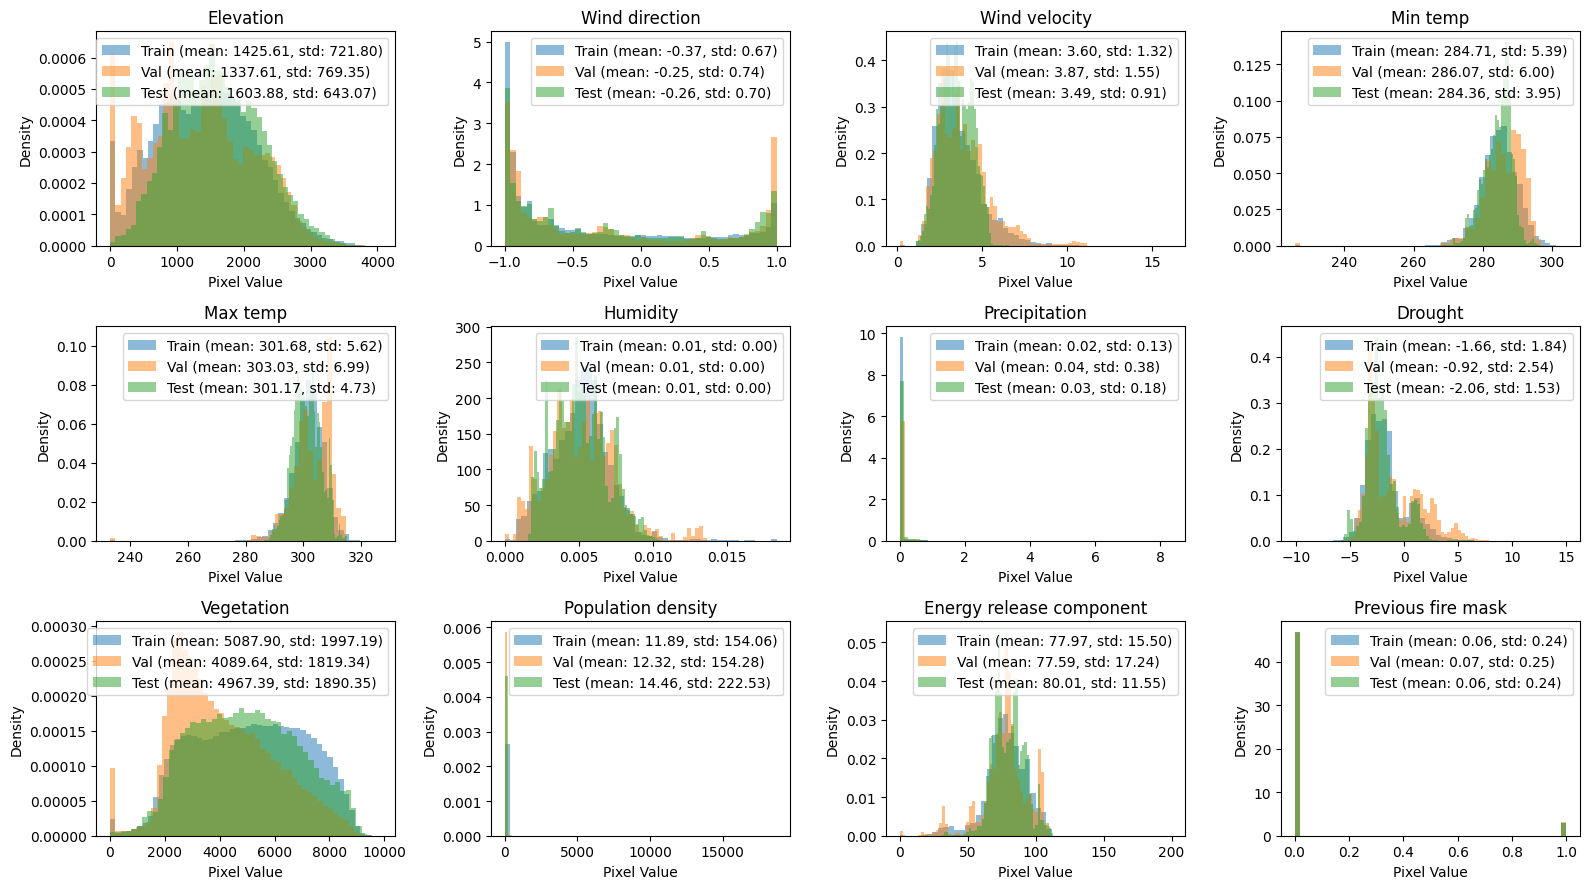

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
INPUT_FEATURES = ['elevation', 'th', 'vs', 'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

variables = ['Elevation', 'Wind direction', 'Wind velocity', 'Min temp',
              'Max temp', 'Humidity', 'Precipitation', 'Drought',
              'Vegetation', 'Population density', 'Energy release component', 'Previous fire mask']

def plot_distributions(train_features, val_features, test_features):
    assert train_features.shape[-1] == val_features.shape[-1] == test_features.shape[-1], "All input datasets must have the same number of features."

    num_channels = train_features.shape[-1]

    num_features = len(INPUT_FEATURES)
    assert num_features == num_channels

    fig, axs = plt.subplots(3, 4, figsize=(16, 9))
    axs = axs.flatten()

    for i, feature_name in enumerate(INPUT_FEATURES):
        train_data = train_features[..., i].flatten()
        val_data = val_features[..., i].flatten()
        test_data = test_features[..., i].flatten()

        ax = axs[i]
        ax.hist(train_data, bins=50, density=True, alpha=0.5, label=f'Train (mean: {np.mean(train_data):.2f}, std: {np.std(train_data):.2f})')
        ax.hist(val_data, bins=50, density=True, alpha=0.5, label=f'Val (mean: {np.mean(val_data):.2f}, std: {np.std(val_data):.2f})')
        ax.hist(test_data, bins=50, density=True, alpha=0.5, label=f'Test (mean: {np.mean(test_data):.2f}, std: {np.std(test_data):.2f})')

        ax.set_title(variables[i])
        ax.set_xlabel("Pixel Value")
        ax.set_ylabel("Density")
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_distributions(train_features, val_features, test_features)


In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
print("Train:\n", np.asarray((unique, counts/counts.sum())).T)
unique, counts = np.unique(val_labels, return_counts=True)
print("Val:\n", np.asarray((unique, counts/counts.sum())).T)
unique, counts = np.unique(test_labels, return_counts=True)
print("Test:\n", np.asarray((unique, counts/counts.sum())).T)

Train:
 [[0.         0.93459069]
 [1.         0.06540931]]
Val:
 [[0.         0.92436278]
 [1.         0.07563722]]
Test:
 [[0.         0.93889984]
 [1.         0.06110016]]


# Dummy Model: Predict the same fire mask as previous-day

In [ ]:
def dummy_model(features):
  return features[:,:,:, 11:]
y_pred_train = dummy_model(train_features)
y_pred_val = dummy_model(val_features)
y_pred_test = dummy_model(test_features)

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

predictions_dict  = {
    'train': {'true': train_labels, 'predictions': y_pred_train},
    'validation': {'true': val_labels, 'predictions': y_pred_val},
    'test': {'true': test_labels, 'predictions': y_pred_test}
}

def compute_metrics(true_labels, predictions, threshold=0.5):

    binary_preds = (predictions >= threshold).astype(int)

    precision = precision_score(true_labels, binary_preds, zero_division=0)
    recall = recall_score(true_labels, binary_preds, zero_division=0)
    f1 = f1_score(true_labels, binary_preds, zero_division=0)

    return {
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    }


for split, data in predictions_dict.items():
    true_labels = data['true'].ravel()
    predictions = data['predictions'].ravel()
    auc_score = roc_auc_score(true_labels, predictions) # metrics with proba
    metrics = compute_metrics(true_labels, predictions) # metrics given a threshold
    print(f"{split.capitalize()}: AUC={auc_score:.2f}, precision={metrics['Precision']:.2f}, recall={metrics['Recall']:.2f}, f1={metrics['F1']:.2f}")


Train: AUC=0.67, precision=0.40, recall=0.37, f1=0.39
Validation: AUC=0.61, precision=0.30, recall=0.26, f1=0.28
Test: AUC=0.69, precision=0.42, recall=0.41, f1=0.42


In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(true_labels, predictions):
    fpr, tpr, thresholds = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression()
train_features_reshaped = train_features.reshape(-1, 12)
train_labels_reshaped = train_labels.reshape(-1, 1)
model.fit(train_features_reshaped, train_labels_reshaped)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

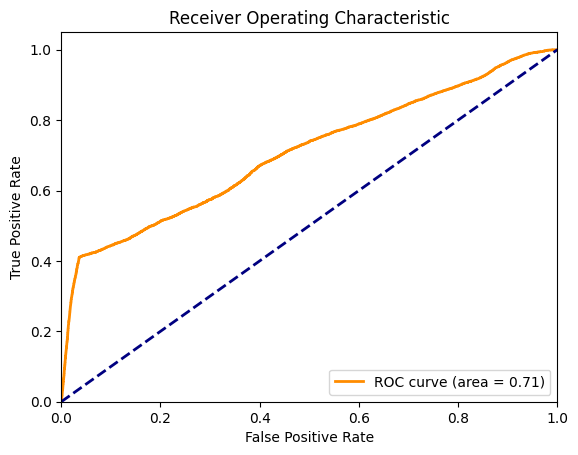

In [ ]:
X_val = test_features.reshape(-1, 12)
y_val = test_labels.reshape(-1, 1)
preds_val = model.predict_proba(X_val)[:, 1]

roc_auc = plot_roc_curve(y_val, preds_val)

We select the threshold hyperparameter on the validation set.

In [ ]:
thresholds = np.linspace(0, 1, num=50)
precisions = []
recalls = []
f1_scores = []

# takes a bit of time to run
for thresh in thresholds:
    metrics = compute_metrics(y_val, preds_val, threshold=thresh)
    precisions.append(metrics['Precision'])
    recalls.append(metrics['Recall'])
    f1_scores.append(metrics['F1'])

opt_threshold = thresholds[np.argmax(f1_scores)] # we can also pick

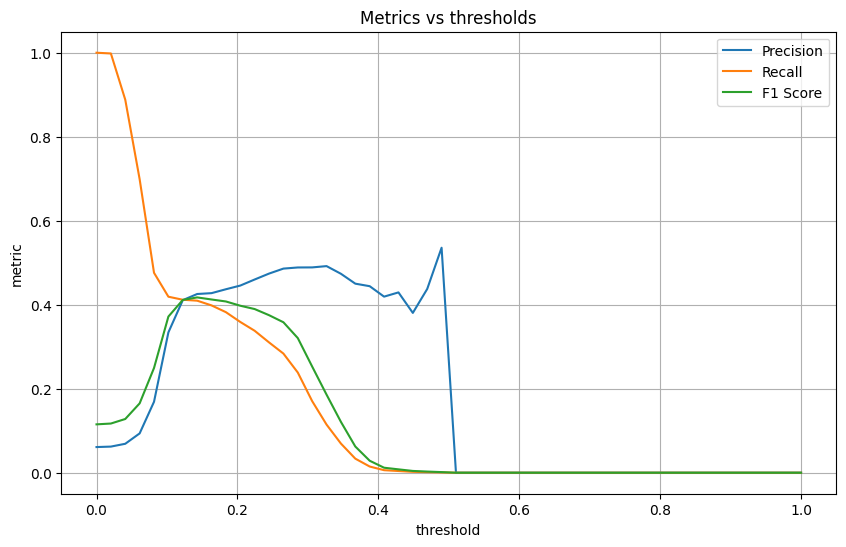

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.title('Metrics vs thresholds')
plt.xlabel('threshold')
plt.ylabel('metric')
plt.legend()
plt.grid(True)
plt.show()

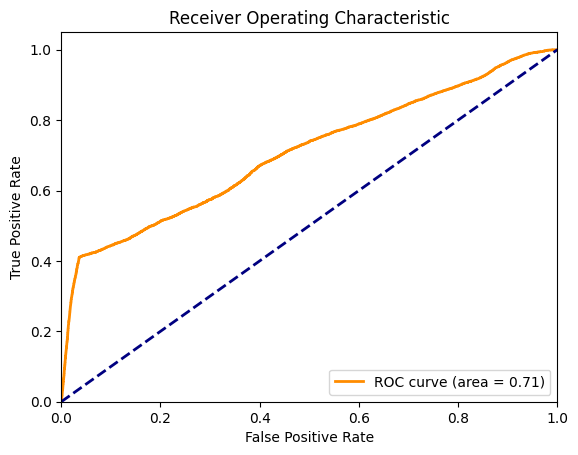

In [ ]:
## TEST scores
X_test = test_features.reshape(-1, 12)
y_test = test_labels.reshape(-1, 1)
preds_test = model.predict_proba(X_test)[:, 1]
split = "Test"
roc_auc = plot_roc_curve(y_test, preds_test)

In [ ]:
metrics = compute_metrics(y_test, preds_test, threshold=opt_threshold)
print(f"{split.capitalize()}: precision={metrics['Precision']:.2f}, recall={metrics['Recall']:.2f}, f1={metrics['F1']:.2f}")

Test: precision=0.43, recall=0.41, f1=0.42


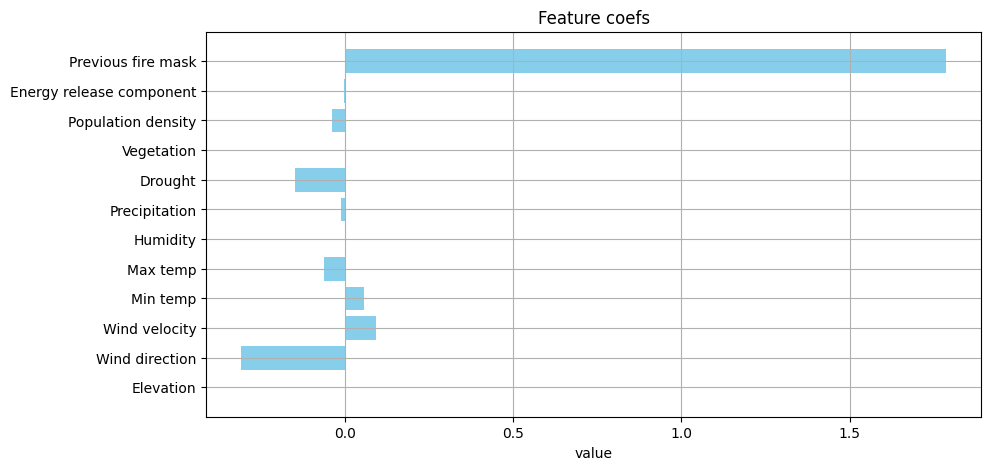

In [ ]:
plt.figure(figsize=(10, 5))
plt.barh(variables, model.coef_.flatten(), color='skyblue')
plt.xlabel('value')
plt.title('Feature coefs')
plt.grid(True)
plt.show()

## Analysis of good pred bad pred, by fire

In [ ]:
preds_test_int = (preds_test>= opt_threshold).astype(int)


In [ ]:
preds_test_reshaped = preds_test_int.reshape(*(test_labels.shape))

In [ ]:
errors = np.mean(np.abs(preds_test_reshaped - test_labels), axis=(1, 2, 3)) # compute mean by fire
N = 5
worst_indices = np.argsort(errors)[-N:]

worst_errors = errors[worst_indices]
print("Indices of worst predicted samples:", worst_indices)
print("Errors:", worst_errors)

Indices of worst predicted samples: [143 229 145 137 131]
Errors: [0.24707031 0.26074219 0.26367188 0.31054688 0.31835938]


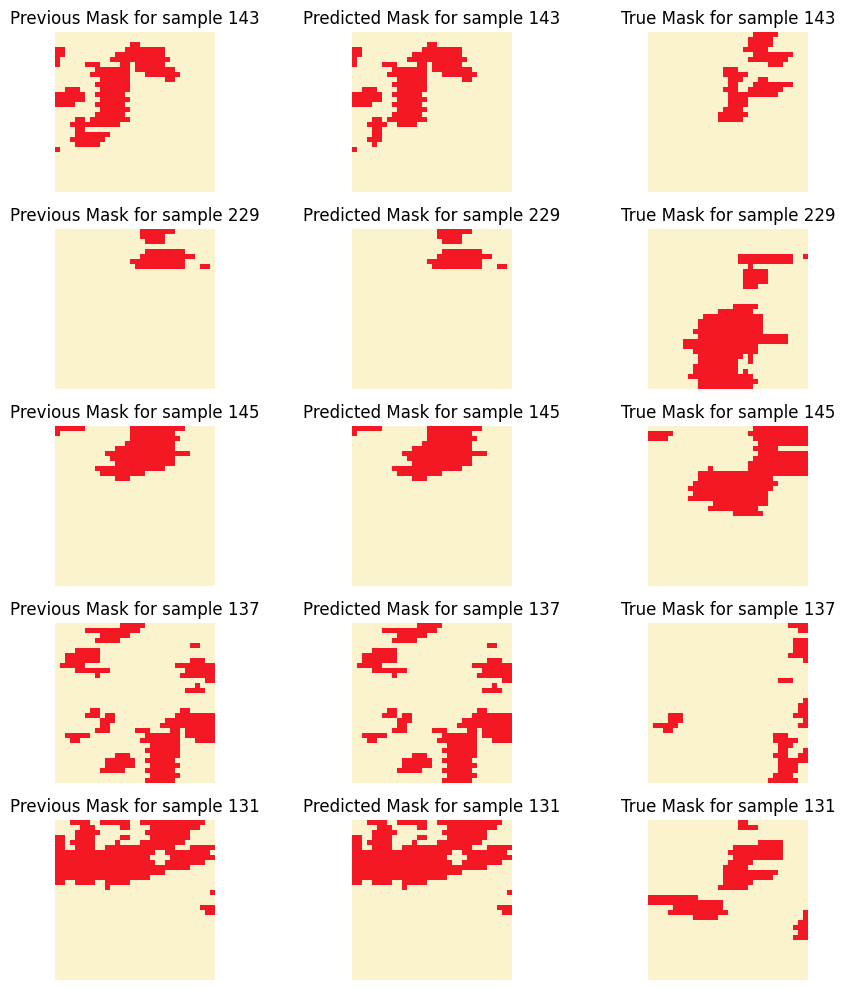

In [ ]:
fig, axes = plt.subplots(nrows=N, ncols=3, figsize=(10, 2 * N))

CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
for idx, sample_index in enumerate(worst_indices):
    ax = axes[idx, 0]
    ax.imshow(test_features[sample_index,:,:,-1].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Previous Mask for sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 1]
    ax.imshow(preds_test_reshaped[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Predicted Mask for sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 2]
    ax.imshow(test_labels[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'True Mask for sample {sample_index}')
    ax.axis('off')

plt.tight_layout()
plt.show()

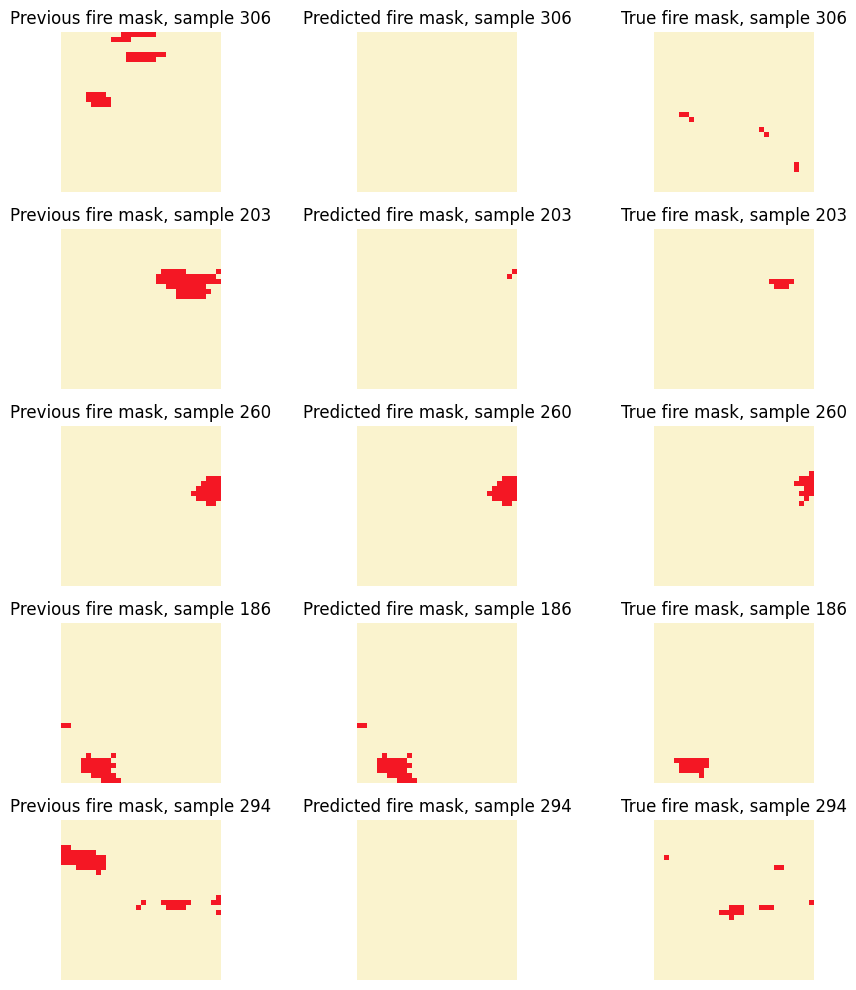

In [ ]:
best_indices = np.argsort(errors)[:N]

fig, axes = plt.subplots(nrows=N, ncols=3, figsize=(10, 2 * N))

CMAP = colors.ListedColormap(['black', "#FAF3CE", '#F41724'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
for idx, sample_index in enumerate(best_indices):
    ax = axes[idx, 0]
    ax.imshow(test_features[sample_index,:,:,-1].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Previous fire mask, sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 1]
    ax.imshow(preds_test_reshaped[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'Predicted fire mask, sample {sample_index}')
    ax.axis('off')

    ax = axes[idx, 2]
    ax.imshow(test_labels[sample_index].reshape(32, 32), cmap=CMAP, norm=NORM)
    ax.set_title(f'True fire mask, sample {sample_index}')
    ax.axis('off')

plt.tight_layout()
plt.show()